## BLSTMs with complete stopword removal and SEQ_LEN 50

In [1]:
import pandas as pd
import numpy as np
from random import shuffle

import gensim
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords

from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Embedding, CuDNNLSTM, Bidirectional
from keras.optimizers import Adam, Adagrad

C:\Users\Aman Deep Singh\Anaconda3\envs\tf-gpu\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
# F1 metrics function
def f1(y_true, y_pred):
    '''returns the f1 score given targets and predictions'''
    
    def recall(y_true, y_pred):
        true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_pos = K.sum(K.round(K.clip(y_true, 0, 1)))
        rec = true_pos / (possible_pos + K.epsilon())
        return rec
    
    def precision(y_true, y_pred):
        true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_pos = K.sum(K.round(K.clip(y_pred, 0, 1)))
        prec = true_pos / (predicted_pos + K.epsilon())
        return prec
    
    _precision = precision(y_true, y_pred)
    _recall = recall(y_true, y_pred)
    return 2 * ((_precision * _recall) / (_precision + _recall + K.epsilon()))

In [3]:
df = pd.read_csv('D:/Datasets/hackerearth/hm_train.csv')
df.drop(['num_sentence'], axis=1, inplace=True)
labels = df.predicted_category
df.drop(['predicted_category'], axis=1, inplace=True)

print(df.shape, len(labels))

(60321, 3) 60321


In [4]:
df.head()

,hmid,reflection_period,cleaned_hm
0,27673,24h,I went on a successful date with someone I fel...
1,27674,24h,I was happy when my son got 90% marks in his e...
2,27675,24h,I went to the gym this morning and did yoga.
3,27676,24h,We had a serious talk with some friends of our...
4,27677,24h,I went with grandchildren to butterfly display...


In [5]:
df.cleaned_hm = df.cleaned_hm.str.lower()

In [6]:
SEQ_LEN = 50
EPOCHS = 20

In [ ]:
def remove_stopwords(sentence):
    # removing some known errors and differences between american and british english
    sentence = sentence.replace("\n", " ").replace(";", " ; ").replace(":", " : ").replace(",", " , ").replace(".", " . ").replace("?", " ? ").replace("/", " / ").replace("\\", " \ ").replace("'s", "").replace("n't", " not").replace("travelled", "traveled").replace("traveller", "traveler").replace("cancelled", "canceled").replace("favourite", "favorite").replace("i'm", "i am").replace("i've", "i have").replace("colour", "color").replace("neighbour", "neighbor").replace("jewellery", "jewelry").replace("theatre", "theater").replace("i'd", "i would").replace("didnt", "did not").replace("doesnt", "does not").replace("wasnt", "was not").replace("programme", "program").replace("organise", "organize")
    
    split = sentence.split()
    if len(split) > SEQ_LEN:
        return ' '.join([w for w in sentence.split() if w not in stopwords.words('english')])
    else:
        return sentence

In [7]:
def completely_remove_stopwords(sentence):
    sentence = sentence.replace("\n", " ").replace(";", " ; ").replace(":", " : ").replace(",", " , ").replace(".", " . ").replace("?", " ? ").replace("/", " / ").replace("\\", " \ ").replace("'s", "").replace("n't", " not").replace("travelled", "traveled").replace("favourite", "favorite").replace("i'm", "i am").replace("i've", "i have").replace("colour", "color").replace("neighbour", "neighbor").replace("jewellery", "jewelry").replace("theatre", "theater").replace("i'd", "i would").replace("didnt", "did not").replace("doesnt", "does not").replace("wasnt", "was not").replace("programme", "program").replace("organise", "organize")
    
    return ' '.join([w for w in sentence.split() if w not in stopwords.words('english')])

In [8]:
df['cleaned_hm2'] = df.cleaned_hm.apply(completely_remove_stopwords)

In [9]:
df.drop(['cleaned_hm'], axis=1, inplace=True)

In [10]:
df.head()

,hmid,reflection_period,cleaned_hm2
0,27673,24h,went successful date someone felt sympathy con...
1,27674,24h,happy son got 90% marks examination
2,27675,24h,went gym morning yoga .
3,27676,24h,serious talk friends flaky lately . understood...
4,27677,24h,went grandchildren butterfly display crohn con...


In [11]:
t = Tokenizer()
t.fit_on_texts(df.cleaned_hm2)
VOCAB_SIZE = len(t.word_index) + 1

In [12]:
encoded_train_set = t.texts_to_sequences(df.cleaned_hm2)
len(encoded_train_set)

60321

In [13]:
lengths = []
for doc in encoded_train_set:
    lengths.append(len(doc))

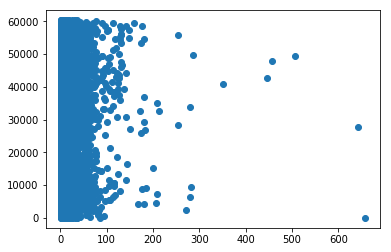

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(lengths, range(len(lengths)))
plt.show()

In [15]:
df['tokens'] = encoded_train_set

In [16]:
df.head()

,hmid,reflection_period,cleaned_hm2,tokens
0,27673,24h,went successful date someone felt sympathy con...,"[4, 661, 229, 200, 47, 12531, 1990]"
1,27674,24h,happy son got 90% marks examination,"[1, 24, 2, 2175, 1318, 2081]"
2,27675,24h,went gym morning yoga .,"[4, 301, 48, 825]"
3,27676,24h,serious talk friends flaky lately . understood...,"[1510, 227, 15, 12532, 1141, 2082, 11, 204, 797]"
4,27677,24h,went grandchildren butterfly display crohn con...,"[4, 1801, 3709, 4111, 12533, 12534]"


In [17]:
df.drop(['cleaned_hm2'], axis=1, inplace=True)

In [18]:
df.head()

,hmid,reflection_period,tokens
0,27673,24h,"[4, 661, 229, 200, 47, 12531, 1990]"
1,27674,24h,"[1, 24, 2, 2175, 1318, 2081]"
2,27675,24h,"[4, 301, 48, 825]"
3,27676,24h,"[1510, 227, 15, 12532, 1141, 2082, 11, 204, 797]"
4,27677,24h,"[4, 1801, 3709, 4111, 12533, 12534]"


In [19]:
np.mean(lengths)

9.304106364284412

In [20]:
padded_train_docs = pad_sequences(encoded_train_set, maxlen=SEQ_LEN, padding='post')

In [21]:
train_paddocs = []
for doc in padded_train_docs:
    train_paddocs.append(list(doc))

In [22]:
df['tokens2'] = train_paddocs

In [23]:
lengths = []
for doc in train_paddocs:
    lengths.append(len(doc))

In [24]:
np.mean(lengths)

50.0

In [25]:
df.drop(['tokens'], axis=1, inplace=True)

In [26]:
df.rename(index=str, columns={'tokens2': 'tokens'}, inplace=True)

In [27]:
df.head()

,hmid,reflection_period,tokens
0,27673,24h,"[4, 661, 229, 200, 47, 12531, 1990, 0, 0, 0, 0..."
1,27674,24h,"[1, 24, 2, 2175, 1318, 2081, 0, 0, 0, 0, 0, 0,..."
2,27675,24h,"[4, 301, 48, 825, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,27676,24h,"[1510, 227, 15, 12532, 1141, 2082, 11, 204, 79..."
4,27677,24h,"[4, 1801, 3709, 4111, 12533, 12534, 0, 0, 0, 0..."


In [28]:
embeddings_index = gensim.models.KeyedVectors.load_word2vec_format('D:/Datasets/embeddings/Word2Vec/GoogleNews-vectors-negative300.bin', binary=True)

In [29]:
VOCAB_SIZE

20705

In [30]:
embedding_matrix = np.zeros((VOCAB_SIZE, 300))
count = 0
for word, i in t.word_index.items():
    try:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        print(f'Did not find {word}')
        count += 1

count

Did not find 10
Did not find mturk
Did not find 24
Did not find 20
Did not find 100
Did not find 30
Did not find 15
Did not find 50
Did not find a
Did not find 12
Did not find 00
Did not find 2017
Did not find 25
Did not find 40
Did not find 11
Did not find 500
Did not find and
Did not find 13
Did not find 000
Did not find 200
Did not find i'll
Did not find donat
Did not find to
Did not find 14
Did not find 300
Did not find 60
Did not find travelling
Did not find judgements
Did not find 250
Did not find cancelled
Did not find 18
Did not find 10th
Did not find 80
Did not find 1000
Did not find 45
Did not find 16
Did not find 70
Did not find 17
Did not find 90
Did not find morty
Did not find ooty
Did not find 2000
Did not find ps4
Did not find 75
Did not find fianca
Did not find 30th
Did not find eudaimonia
Did not find jigarthanda
Did not find a3i
Did not find iave
Did not find 2016
Did not find 150
Did not find 99
Did not find '
Did not find thatas
Did not find learnt
Did not find euda

Did not find ggod
Did not find loyal3
Did not find clup
Did not find frenchies
Did not find bffs
Did not find noddle
Did not find educatiion
Did not find wondercon
Did not find psat
Did not find shortfilm
Did not find ryzen
Did not find babysiting
Did not find powerwalked
Did not find 20as
Did not find 30as
Did not find selfieeeeee
Did not find 'halfway
Did not find fifty'
Did not find apartmentas
Did not find aplease
Did not find allaha
Did not find beehouse
Did not find austalia
Did not find patricks
Did not find 'elephant
Did not find doppelga
Did not find crowdlab
Did not find 35mph
Did not find barkfast
Did not find dennar
Did not find traviling
Did not find orkavt
Did not find zafu
Did not find guayama
Did not find increament
Did not find withinaaafrom
Did not find whyaaanot
Did not find asideaaahealthy
Did not find headachesaaawhich
Did not find placeboaaareplace
Did not find 1500m
Did not find materialised
Did not find 'cheeseburger
Did not find quesadillas'
Did not find favara

Did not find 39th
Did not find ibotta
Did not find daazs
Did not find hayward
Did not find mulan
Did not find 100000
Did not find shevaroys
Did not find rockville
Did not find 'diary
Did not find kid'
Did not find floot
Did not find 1sr
Did not find miyazaki
Did not find picross
Did not find trecking
Did not find narasimhaswami
Did not find tirunalla
Did not find houes
Did not find nephews'
Did not find 'me
Did not find time'
Did not find 20minute
Did not find wellcare
Did not find 92nd
Did not find 1800
Did not find xanth
Did not find walkinging
Did not find cince
Did not find days'
Did not find bladerunner
Did not find 2049
Did not find scannings
Did not find 'pineapple'
Did not find minpin
Did not find sweedish
Did not find hersey
Did not find sheetz
Did not find goseigen
Did not find raddison
Did not find amway
Did not find brussel
Did not find reasult
Did not find meeat
Did not find exciste
Did not find staminas
Did not find 65th
Did not find 88th
Did not find majora
Did not find 

2601

In [31]:
embedding_matrix.shape

(20705, 300)

In [32]:
df['24h'] = df.reflection_period == '24h'
df['3m'] = df.reflection_period == '3m'

In [33]:
df.drop(['reflection_period'], axis=1, inplace=True)

In [34]:
df.head()

,hmid,tokens,24h,3m
0,27673,"[4, 661, 229, 200, 47, 12531, 1990, 0, 0, 0, 0...",True,False
1,27674,"[1, 24, 2, 2175, 1318, 2081, 0, 0, 0, 0, 0, 0,...",True,False
2,27675,"[4, 301, 48, 825, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",True,False
3,27676,"[1510, 227, 15, 12532, 1141, 2082, 11, 204, 79...",True,False
4,27677,"[4, 1801, 3709, 4111, 12533, 12534, 0, 0, 0, 0...",True,False


In [35]:
print(df.shape, len(labels))

(60321, 4) 60321


In [36]:
df.to_csv('D:/Datasets/hackerearth/hm_train-tok-nstp.csv')

In [37]:
labels_to_cats = {'achievement':      (1, 0, 0, 0, 0, 0, 0),
                  'affection':        (0, 1, 0, 0, 0, 0, 0),
                  'enjoy_the_moment': (0, 0, 1, 0, 0, 0, 0),
                  'nature':           (0, 0, 0, 1, 0, 0, 0),
                  'exercise':         (0, 0, 0, 0, 1, 0, 0),
                  'bonding':          (0, 0, 0, 0, 0, 1, 0),
                  'leisure':          (0, 0, 0, 0, 0, 0, 1)}

In [38]:
cats_to_labels = dict()
for k, v in labels_to_cats.items():
    cats_to_labels[v] = k

cats_to_labels

{(1, 0, 0, 0, 0, 0, 0): 'achievement',
 (0, 1, 0, 0, 0, 0, 0): 'affection',
 (0, 0, 1, 0, 0, 0, 0): 'enjoy_the_moment',
 (0, 0, 0, 1, 0, 0, 0): 'nature',
 (0, 0, 0, 0, 1, 0, 0): 'exercise',
 (0, 0, 0, 0, 0, 1, 0): 'bonding',
 (0, 0, 0, 0, 0, 0, 1): 'leisure'}

In [39]:
y = []
for label in labels:
    y.append(labels_to_cats[label])

y = np.array(y)
len(y)

60321

In [40]:
len(df.tokens[0])

50

In [41]:
input_tensor = Input(shape=(SEQ_LEN,), dtype='int32')
e = Embedding(VOCAB_SIZE, 300, weights=[embedding_matrix], input_length=SEQ_LEN, trainable=False)(input_tensor)
x = Bidirectional(CuDNNLSTM(256, return_sequences=True))(e)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
x = Bidirectional(CuDNNLSTM(64, return_sequences=False))(x)
x = Dense(64, activation='relu')(x)
x = Dense(7, activation='softmax')(x)
model = Model(input_tensor, x)

In [42]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', f1])

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           6211500   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 512)           1142784   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 256)           657408    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164864    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 455       
Total para

In [44]:
x_train, x_val, y_train, y_val = train_test_split(df, y, test_size=0.2)

In [45]:
print(x_train.shape, x_val.shape)

(48256, 4) (12065, 4)


In [46]:
print(y_train.shape, y_val.shape)

(48256, 7) (12065, 7)


In [47]:
x_train_reshape = x_train.copy()
x_train_reshape = x_train_reshape.tokens

In [48]:
x_train_new = []
for element in x_train_reshape:
    x_train_new.append(np.array(element))
x_train_new = np.array(x_train_new)
x_train_new.shape

(48256, 50)

In [49]:
x_val_reshape = x_val.copy()
x_val_reshape = x_val_reshape.tokens

In [50]:
x_val_new = []
for element in x_val_reshape:
    x_val_new.append(np.array(element))
x_val_new = np.array(x_val_new)
x_val_new.shape

(12065, 50)

In [50]:
%whos

Variable                      Type                    Data/Info
---------------------------------------------------------------
Adagrad                       type                    <class 'keras.optimizers.Adagrad'>
Adam                          type                    <class 'keras.optimizers.Adam'>
Bidirectional                 type                    <class 'keras.layers.wrappers.Bidirectional'>
CuDNNLSTM                     type                    <class 'keras.layers.cudnn_recurrent.CuDNNLSTM'>
Dense                         type                    <class 'keras.layers.core.Dense'>
EPOCHS                        int                     20
Embedding                     type                    <class 'keras.layers.embeddings.Embedding'>
Flatten                       type                    <class 'keras.layers.core.Flatten'>
Input                         function                <function Input at 0x0000028ED3D14A60>
K                             module                  <module 'keras

In [51]:
model.fit(x_train_new, y_train, epochs=2 * EPOCHS, verbose=2)

Epoch 1/40
 - 43s - loss: 0.7344 - acc: 0.7484 - f1: 0.7227
Epoch 2/40
 - 44s - loss: 0.4634 - acc: 0.8398 - f1: 0.8393
Epoch 3/40
 - 42s - loss: 0.4147 - acc: 0.8533 - f1: 0.8528
Epoch 4/40
 - 41s - loss: 0.3870 - acc: 0.8620 - f1: 0.8617
Epoch 5/40
 - 40s - loss: 0.3691 - acc: 0.8664 - f1: 0.8660
Epoch 6/40
 - 41s - loss: 0.3510 - acc: 0.8718 - f1: 0.8722
Epoch 7/40
 - 39s - loss: 0.3353 - acc: 0.8766 - f1: 0.8764
Epoch 8/40
 - 39s - loss: 0.3203 - acc: 0.8825 - f1: 0.8822
Epoch 9/40
 - 39s - loss: 0.3079 - acc: 0.8870 - f1: 0.8865
Epoch 10/40
 - 39s - loss: 0.2903 - acc: 0.8938 - f1: 0.8938
Epoch 11/40
 - 39s - loss: 0.2777 - acc: 0.8970 - f1: 0.8969
Epoch 12/40
 - 39s - loss: 0.2645 - acc: 0.9024 - f1: 0.9032
Epoch 13/40
 - 39s - loss: 0.2503 - acc: 0.9069 - f1: 0.9073
Epoch 14/40
 - 39s - loss: 0.2383 - acc: 0.9112 - f1: 0.9117
Epoch 15/40
 - 39s - loss: 0.2257 - acc: 0.9158 - f1: 0.9160
Epoch 16/40
 - 39s - loss: 0.2140 - acc: 0.9203 - f1: 0.9205
Epoch 17/40
 - 39s - loss: 0.1976

In [52]:
model.save('D:/Datasets/hackerearth/models/word2vec-50-nstp-blstm256-bltsm128-blstm64-d64-e40.h5')

In [ ]:
df_test = pd.read_csv('D:/Datasets/hackerearth/hm_test.csv')
df_test.drop(['num_sentence'], axis=1, inplace=True)
df_test.head()

In [ ]:
len(df_test)

In [ ]:
df_test.cleaned_hm = df_test.cleaned_hm.str.lower()
df_test['cleaned_hm2'] = df_test.cleaned_hm.apply(remove_stopwords)
df_test.drop(['cleaned_hm'], axis=1, inplace=True)
df_test.head()

In [ ]:
encoded_test_set = t.texts_to_sequences(df_test.cleaned_hm2)
lengths = []
for doc in encoded_test_set:
    lengths.append(len(doc))
    
plt.scatter(lengths, range(len(lengths)))
plt.show()

In [ ]:
df_test['tokens'] = encoded_test_set

In [ ]:
df_test.head()

In [ ]:
df_test.drop(['cleaned_hm2'], axis=1, inplace=True)
df_test.head()

In [ ]:
np.mean(lengths)

In [ ]:
padded_test_set = pad_sequences(encoded_test_set, maxlen=SEQ_LEN, padding='post')
paddocs_test = []
for doc in padded_test_set:
    paddocs_test.append(list(doc))
    
df_test['tokens2'] = paddocs_test
lengths = []
for doc in paddocs_test:
    lengths.append(len(doc))
np.mean(lengths)

In [ ]:
df_test.drop(['tokens'], axis=1, inplace=True)
df_test['tokens'] = df_test.tokens2
df_test.drop(['tokens2'], axis=1, inplace=True)
df_test.head()

In [ ]:
df_test['24h'] = df_test.reflection_period == '24h'
df_test['3m'] = df_test.reflection_period == '3m'
df_test.drop(['reflection_period'], axis=1, inplace=True)
df_test.head()

In [ ]:
df_test.shape

In [ ]:
x_test = df_test.tokens
x_test_reshape = x_test.copy()
x_test_reshape.shape
x_test_new = []
for element in x_test_reshape:
    x_test_new.append(np.array(element))

In [ ]:
x_test_new = np.array(x_test_new)
x_test_new.shape

In [ ]:
np.save('D:/Datasets/hackerearth/test_40213_120.npy', arr=x_test_new)

In [ ]:
preds = model.predict(x_test_new, batch_size=256)

In [ ]:
preds[0]

In [ ]:
preds.shape

In [ ]:
categories = []
for pred in preds:
    dummy = np.zeros((7,))
    dummy[np.argmax(pred)] = 1
    categories.append(cats_to_labels[tuple(dummy)])
categories[:5]

In [ ]:
len(categories)

In [53]:
score = model.evaluate(x_val_new, y_val, batch_size=128, verbose=2)

In [54]:
score

[0.7660568556225354, 0.8600911728880289, 0.860419652148791]

In [55]:
input_tensor = Input(shape=(SEQ_LEN,), dtype='int32')
e = Embedding(VOCAB_SIZE, 300, weights=[embedding_matrix], input_length=SEQ_LEN, trainable=False)(input_tensor)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(e)
x = Bidirectional(CuDNNLSTM(64, return_sequences=False))(x)
x = Dense(64, activation='relu')(x)
x = Dense(7, activation='softmax')(x)
model2 = Model(input_tensor, x)

In [56]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 300)           6211500   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 256)           440320    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               164864    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 455       
Total params: 6,825,395
Trainable params: 613,895
Non-trainable params: 6,211,500
____________________________________________________________

In [57]:
model2.compile(optimizer=Adam(lr=1e-4, decay=1e-7), loss='categorical_crossentropy', metrics=['accuracy', f1])

In [58]:
model2.fit(x_train_new, y_train, epochs=EPOCHS, verbose=2)

Epoch 1/20
 - 30s - loss: 0.7392 - acc: 0.7529 - f1: 0.7126
Epoch 2/20
 - 30s - loss: 0.4801 - acc: 0.8341 - f1: 0.8310
Epoch 3/20
 - 28s - loss: 0.4295 - acc: 0.8488 - f1: 0.8474
Epoch 4/20
 - 30s - loss: 0.4033 - acc: 0.8561 - f1: 0.8556
Epoch 5/20
 - 30s - loss: 0.3817 - acc: 0.8625 - f1: 0.8624
Epoch 6/20
 - 28s - loss: 0.3678 - acc: 0.8665 - f1: 0.8672
Epoch 7/20
 - 33s - loss: 0.3535 - acc: 0.8706 - f1: 0.8706
Epoch 8/20
 - 32s - loss: 0.3394 - acc: 0.8751 - f1: 0.8752
Epoch 9/20
 - 34s - loss: 0.3256 - acc: 0.8819 - f1: 0.8816
Epoch 10/20
 - 28s - loss: 0.3166 - acc: 0.8840 - f1: 0.8842
Epoch 11/20
 - 31s - loss: 0.3037 - acc: 0.8894 - f1: 0.8886
Epoch 12/20
 - 30s - loss: 0.2920 - acc: 0.8932 - f1: 0.8933
Epoch 13/20
 - 28s - loss: 0.2825 - acc: 0.8952 - f1: 0.8954
Epoch 14/20
 - 28s - loss: 0.2693 - acc: 0.9008 - f1: 0.9008
Epoch 15/20
 - 27s - loss: 0.2594 - acc: 0.9047 - f1: 0.9045
Epoch 16/20
 - 27s - loss: 0.2470 - acc: 0.9101 - f1: 0.9102
Epoch 17/20
 - 27s - loss: 0.2382

In [59]:
model2.save('D:/Datasets/hackerearth/models/word2vec-50-nstp-blstm128-bltsm64-d64-e20.h5')

In [60]:
score = model2.evaluate(x_val_new, y_val, batch_size=256, verbose=2)

In [61]:
score

[0.4062826569106042, 0.8678823042548252, 0.8684861156291306]

In [62]:
input_tensor = Input(shape=(SEQ_LEN,), dtype='int32')
e = Embedding(VOCAB_SIZE, 300, weights=[embedding_matrix], input_length=SEQ_LEN, trainable=False)(input_tensor)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(e)
x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(7, activation='softmax')(x)
model3 = Model(input_tensor, x)

In [63]:
model3.compile(optimizer=Adam(lr=1e-4, decay=1e-7), loss='categorical_crossentropy', metrics=['accuracy', f1])

In [64]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 300)           6211500   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 50, 256)           440320    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 50, 128)           164864    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               819328    
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 903       
Total para

In [65]:
model3.fit(x_train_new, y_train, epochs=10, verbose=2)

Epoch 1/10
 - 30s - loss: 0.6147 - acc: 0.7867 - f1: 0.7636
Epoch 2/10
 - 35s - loss: 0.4263 - acc: 0.8485 - f1: 0.8469
Epoch 3/10
 - 36s - loss: 0.3888 - acc: 0.8603 - f1: 0.8597
Epoch 4/10
 - 32s - loss: 0.3663 - acc: 0.8673 - f1: 0.8669
Epoch 5/10
 - 32s - loss: 0.3473 - acc: 0.8733 - f1: 0.8728
Epoch 6/10
 - 29s - loss: 0.3304 - acc: 0.8786 - f1: 0.8779
Epoch 7/10
 - 32s - loss: 0.3154 - acc: 0.8842 - f1: 0.8841
Epoch 8/10
 - 33s - loss: 0.2999 - acc: 0.8891 - f1: 0.8897
Epoch 9/10
 - 28s - loss: 0.2830 - acc: 0.8959 - f1: 0.8957
Epoch 10/10
 - 29s - loss: 0.2695 - acc: 0.8989 - f1: 0.9000


In [66]:
model3.save('D:/Datasets/hackerearth/models/word2vec-50-nstp-blstm128-bltsm64-f-d128-e10.h5')

In [67]:
score = model3.evaluate(x_val_new, y_val, batch_size=256, verbose=2)

In [68]:
score

[0.38994654776197324, 0.8649813510005128, 0.8675901372651069]